In [1]:
import os
os.chdir('/content/drive/MyDrive/fraud_detection')

import kaggle_dataset_downloader, data_setup, model_builder, engine, utils
import pandas as pd
import torch
from torch import nn

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Working on: {device}")

PyTorch version: 2.0.1+cu118
Working on: cuda


# 1. Data setup

## 1.1 Download and analyze data

Steps include:
- Downloading the credit card fraud detection dataset from Kaggle through **download_data** method from the **kaggle_dataset_downloader.py** file.

- Analyzing the data using helper functions from the file **utils.py**.


In [2]:
# Specify path to download the data
DATASET = "mlg-ulb/creditcardfraud"
DOWNLOAD_PATH = "/content/drive/MyDrive/fraud_detection/data"
kaggle_dataset_downloader.download_data(dataset=DATASET,
                                        download_path=DOWNLOAD_PATH)

Data already exists in the specified directory: /content/drive/MyDrive/fraud_detection/data


In [3]:
DATA_PATH = DOWNLOAD_PATH + "/creditcard.csv"
df = pd.read_csv(DATA_PATH)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


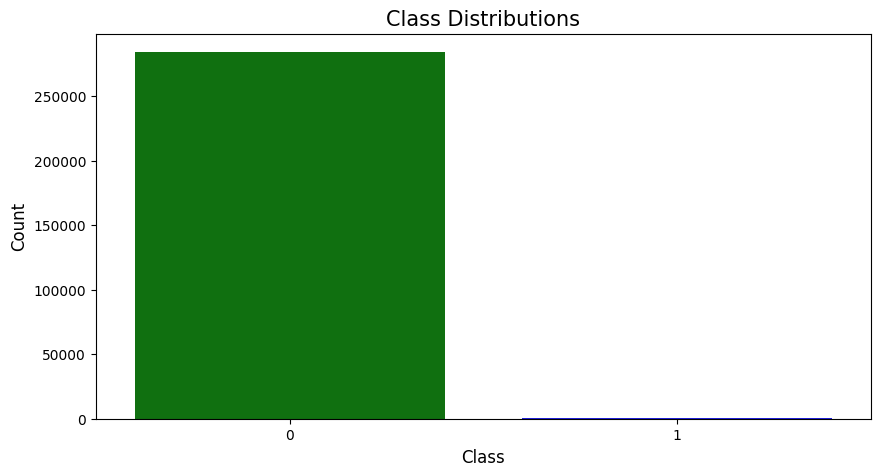

In [5]:
utils.visualize_class_distributions(data_frame=df,
                              class_column="Class")

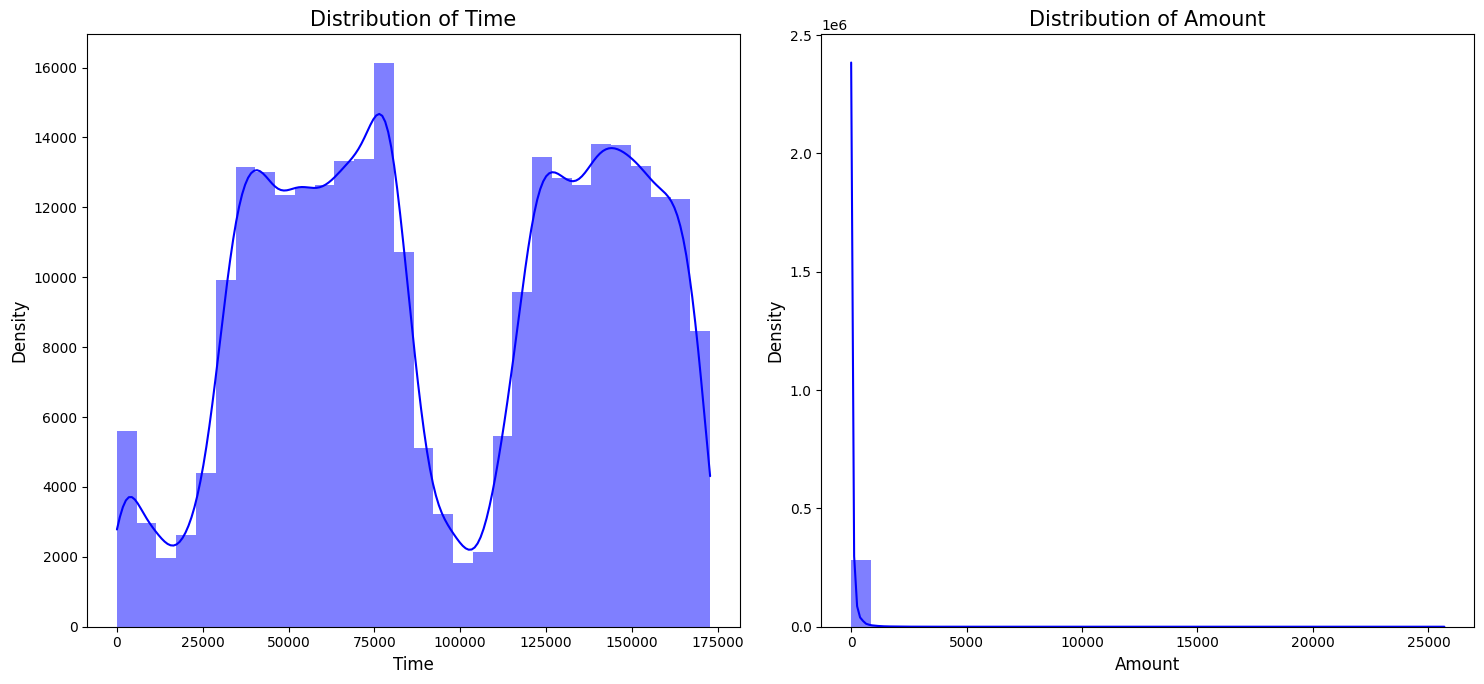

In [6]:
features = ["Time", "Amount"]
utils.visualize_feature_distributions(data_frame=df,
                                features=features)

## 1.2 Data into Dataloaders

Steps include:
- Having the training dataloader and test dataloader using **create_dataloaders** method from the **data_setup.py** file.


In [7]:
X = df.drop("Class", axis=1)
y = df["Class"]

len(X), len(y)

(284807, 284807)

In [8]:
train_loader, test_loader = data_setup.create_dataloaders(X=X,
                                                          y=y,
                                                          batch_size=32,
                                                          dtype=torch.float32,
                                                          sampling="undersampling",
                                                          test_size=0.2)

Undersampling applied
New class counts: Counter({0: 492, 1: 492})
Shape of X_train: (787, 30) | Length of X_train: 787
Shape of y_train: (787,) | Length of y_train: 787
Shape of X_test: (197, 30) | Length of X_test: 197
Shape of y_test: (197,) | Length of y_test: 197


# 2. Initializing, training and evaluating the model

## 2.1 Build the model

Steps include:
- Initialize the **FraudDetectionModel** network specified in the **model_builder.py** file. Network architecture can be seen there.

- Define the loss function and optimizer.

- Train the network using **train** function defined in **engine.py**

- Visualize the results using **visualize_results** method from **utils.py**

In [9]:
model_0 = model_builder.FraudDetectionModel(input_shape=30,
                                            output_shape=1,
                                            hidden_units=64).to(device)
model_0

FraudDetectionModel(
  (net): Sequential(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=30, out_features=64, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [10]:
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

In [11]:
EPOCHS = 20
results = engine.train(model=model_0,
                     train_dataloader=train_loader,
                     test_dataloader=test_loader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=EPOCHS,
                     device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4759 | train_acc: 0.7975 | test_loss: 0.3880 | test_acc: 0.8929
Epoch: 2 | train_loss: 0.2895 | train_acc: 0.9016 | test_loss: 0.2305 | test_acc: 0.9152
Epoch: 3 | train_loss: 0.2380 | train_acc: 0.9054 | test_loss: 0.1778 | test_acc: 0.9420
Epoch: 4 | train_loss: 0.2411 | train_acc: 0.9116 | test_loss: 0.1716 | test_acc: 0.9420
Epoch: 5 | train_loss: 0.1997 | train_acc: 0.9237 | test_loss: 0.1685 | test_acc: 0.9554
Epoch: 6 | train_loss: 0.1858 | train_acc: 0.9312 | test_loss: 0.1626 | test_acc: 0.9598
Epoch: 7 | train_loss: 0.1872 | train_acc: 0.9345 | test_loss: 0.1590 | test_acc: 0.9554
Epoch: 8 | train_loss: 0.1501 | train_acc: 0.9475 | test_loss: 0.1630 | test_acc: 0.9554
Epoch: 9 | train_loss: 0.1607 | train_acc: 0.9424 | test_loss: 0.1515 | test_acc: 0.9554
Epoch: 10 | train_loss: 0.1497 | train_acc: 0.9441 | test_loss: 0.1496 | test_acc: 0.9509
Epoch: 11 | train_loss: 0.1604 | train_acc: 0.9429 | test_loss: 0.1588 | test_acc: 0.9509
Epoch: 12 | train_l

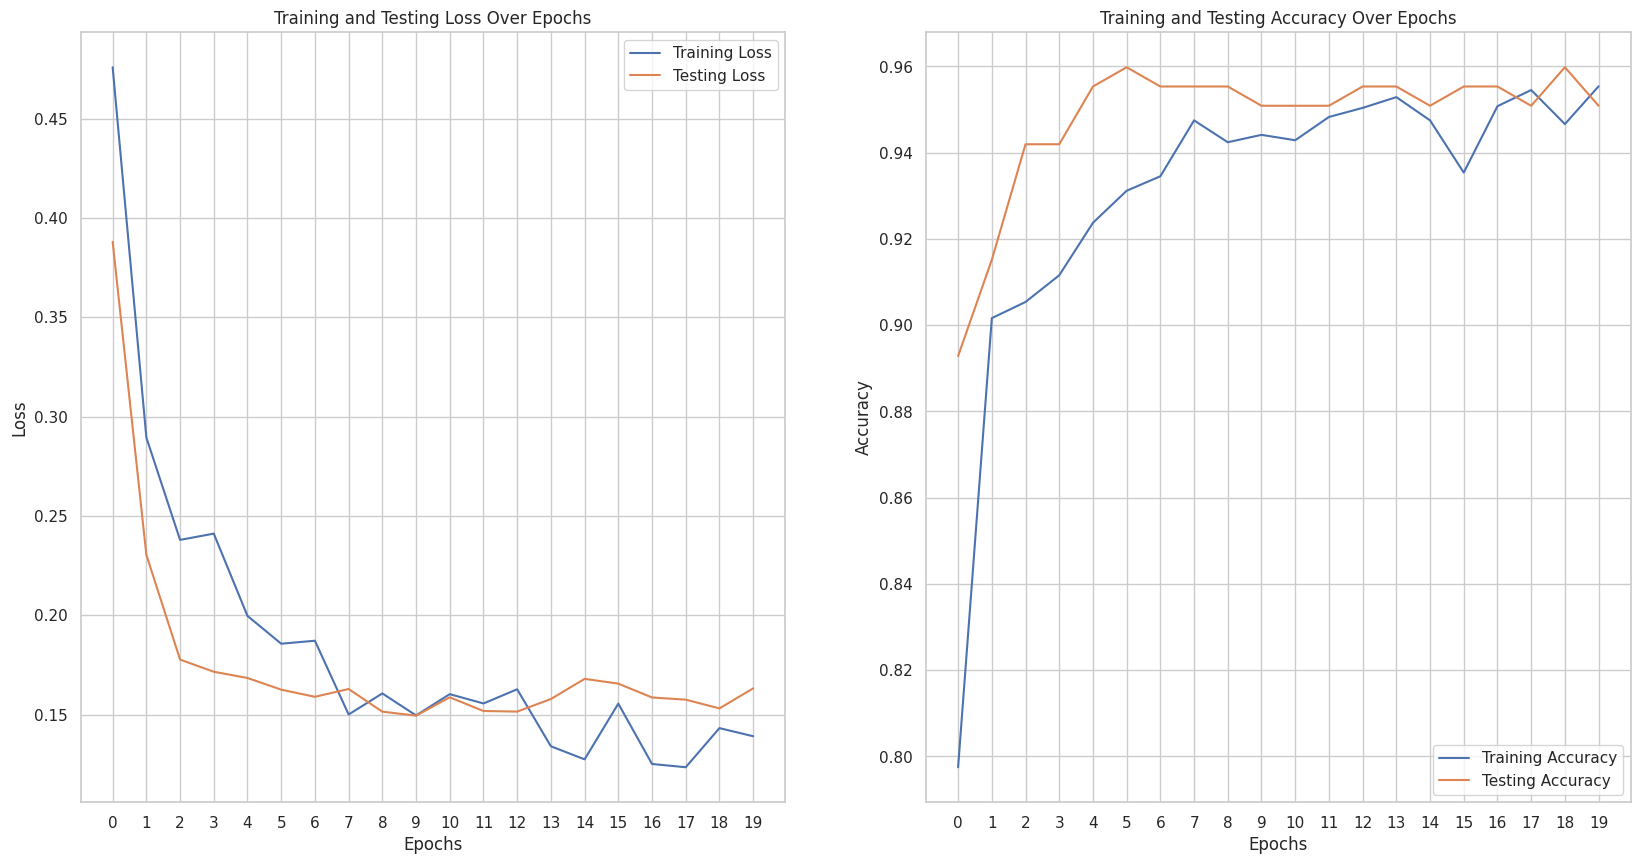

In [12]:
utils.visualize_results(results)